# Project : German Credit Risk Analysis

In [2]:
# Install ucimlrepo if it is not already installed
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: C:\Users\liuja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import required libraries

In [3]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

### Gather and Structure the Data

In [4]:
# Load dataset (German Credit Data from UCI)
statlog_data = fetch_ucirepo(id=144)
X = statlog_data.data.features
y = statlog_data.data.targets

In [5]:
# Rename columns based on UCI documentation
X.columns = [
    "Status_checking_account", "Duration_month", "Credit_history", "Purpose",
    "Credit_amount", "Savings_account", "Employment_since", "Installment_rate",
    "Personal_status_sex", "Other_debtors_guarantors", "Residence_since",
    "Property", "Age_years", "Other_installment_plans", "Housing",
    "Existing_credits", "Job", "Num_liable", "Telephone", "Foreign_worker"
]

# Convert target: 1 = good credit, 2 = bad credit
y = y.replace({1: "Good", 2: "Bad"})
if isinstance(y, pd.DataFrame):
    y = y.rename(columns={y.columns[0]: "Credit_risk"})
else:
    y = y.rename("Credit_risk")

# Combine features and target
df = pd.concat([X, y], axis=1)

### 1. Descriptive Analysis

#### 1.1 Univariate Visualisation

In [6]:
print("Dataset overview")
print(df.head(), "\n")
print("Shape:", df.shape, "\n")
print("Data types:\n", df.dtypes, "\n")
print("Target distribution:\n", df["Credit_risk"].value_counts(), "\n")
print("Numeric summary:\n", df.describe(), "\n")

Dataset overview
  Status_checking_account  Duration_month Credit_history Purpose  \
0                     A11               6            A34     A43   
1                     A12              48            A32     A43   
2                     A14              12            A34     A46   
3                     A11              42            A32     A42   
4                     A11              24            A33     A40   

   Credit_amount Savings_account Employment_since  Installment_rate  \
0           1169             A65              A75                 4   
1           5951             A61              A73                 2   
2           2096             A61              A74                 2   
3           7882             A61              A74                 2   
4           4870             A61              A73                 3   

  Personal_status_sex Other_debtors_guarantors  ...  Property Age_years  \
0                 A93                     A101  ...      A121        67 

The dataset contains 1,000 observations and 21 columns (20 features + 1 target).

There are no missing values, meaning the dataset is clean and ready for preprocessing.



Identify numerical and categorical features

In [7]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numeric_cols)
print("Categorical features:", categorical_cols)

Numerical features: ['Duration_month', 'Credit_amount', 'Installment_rate', 'Residence_since', 'Age_years', 'Existing_credits', 'Num_liable']
Categorical features: ['Status_checking_account', 'Credit_history', 'Purpose', 'Savings_account', 'Employment_since', 'Personal_status_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job', 'Telephone', 'Foreign_worker', 'Credit_risk']


Histograms for numerical variables

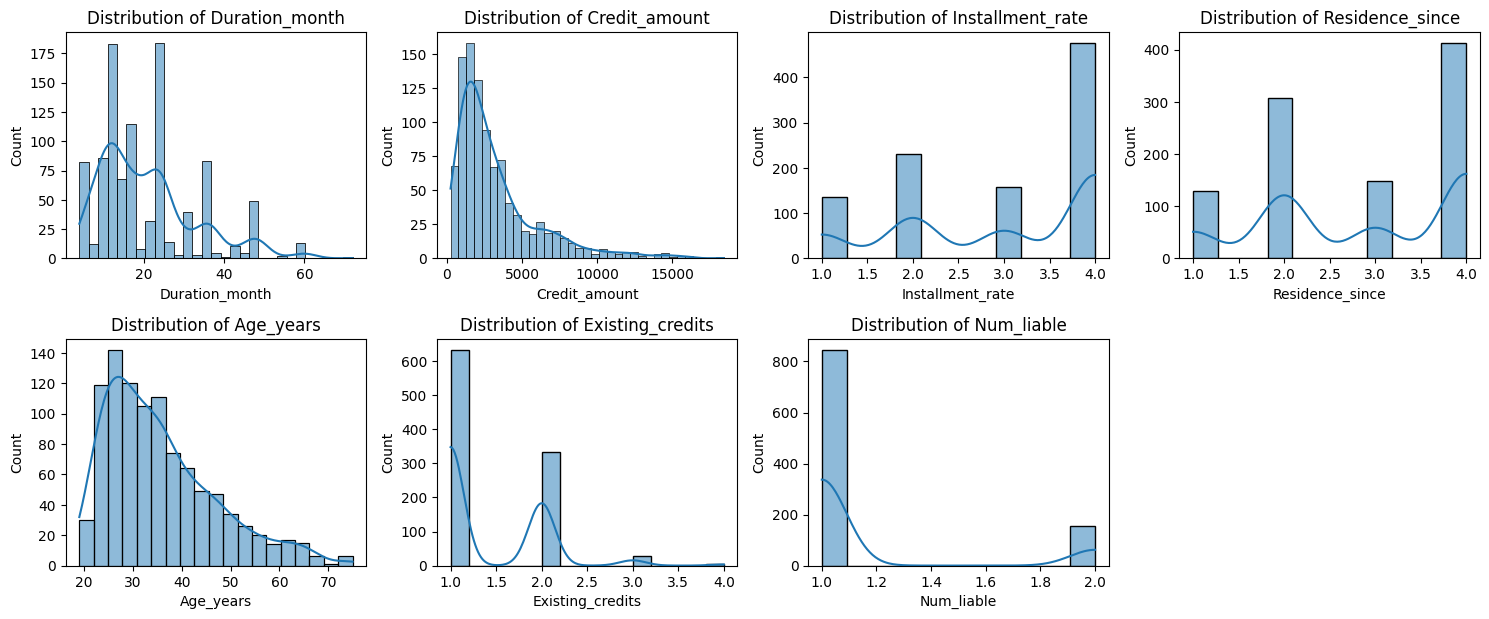

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Boxplots for numerical variables (outlier detection)

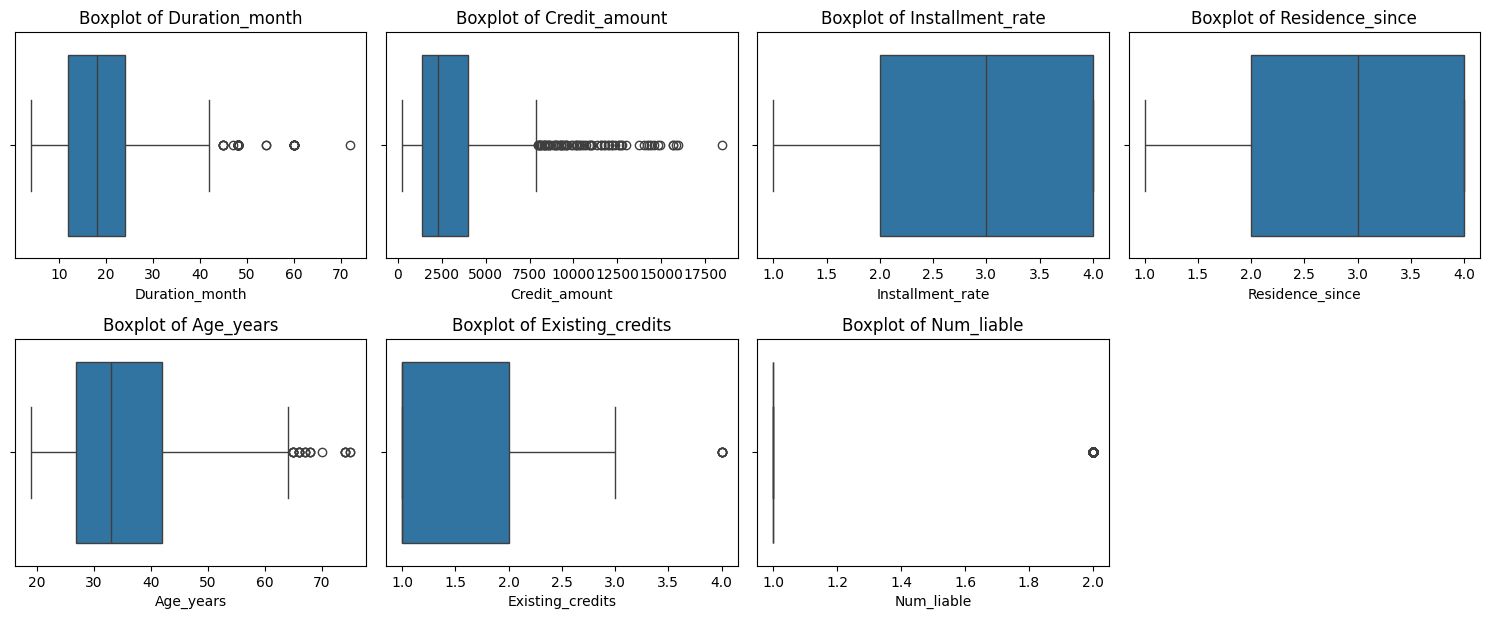

In [9]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

Barplots for categorical variables

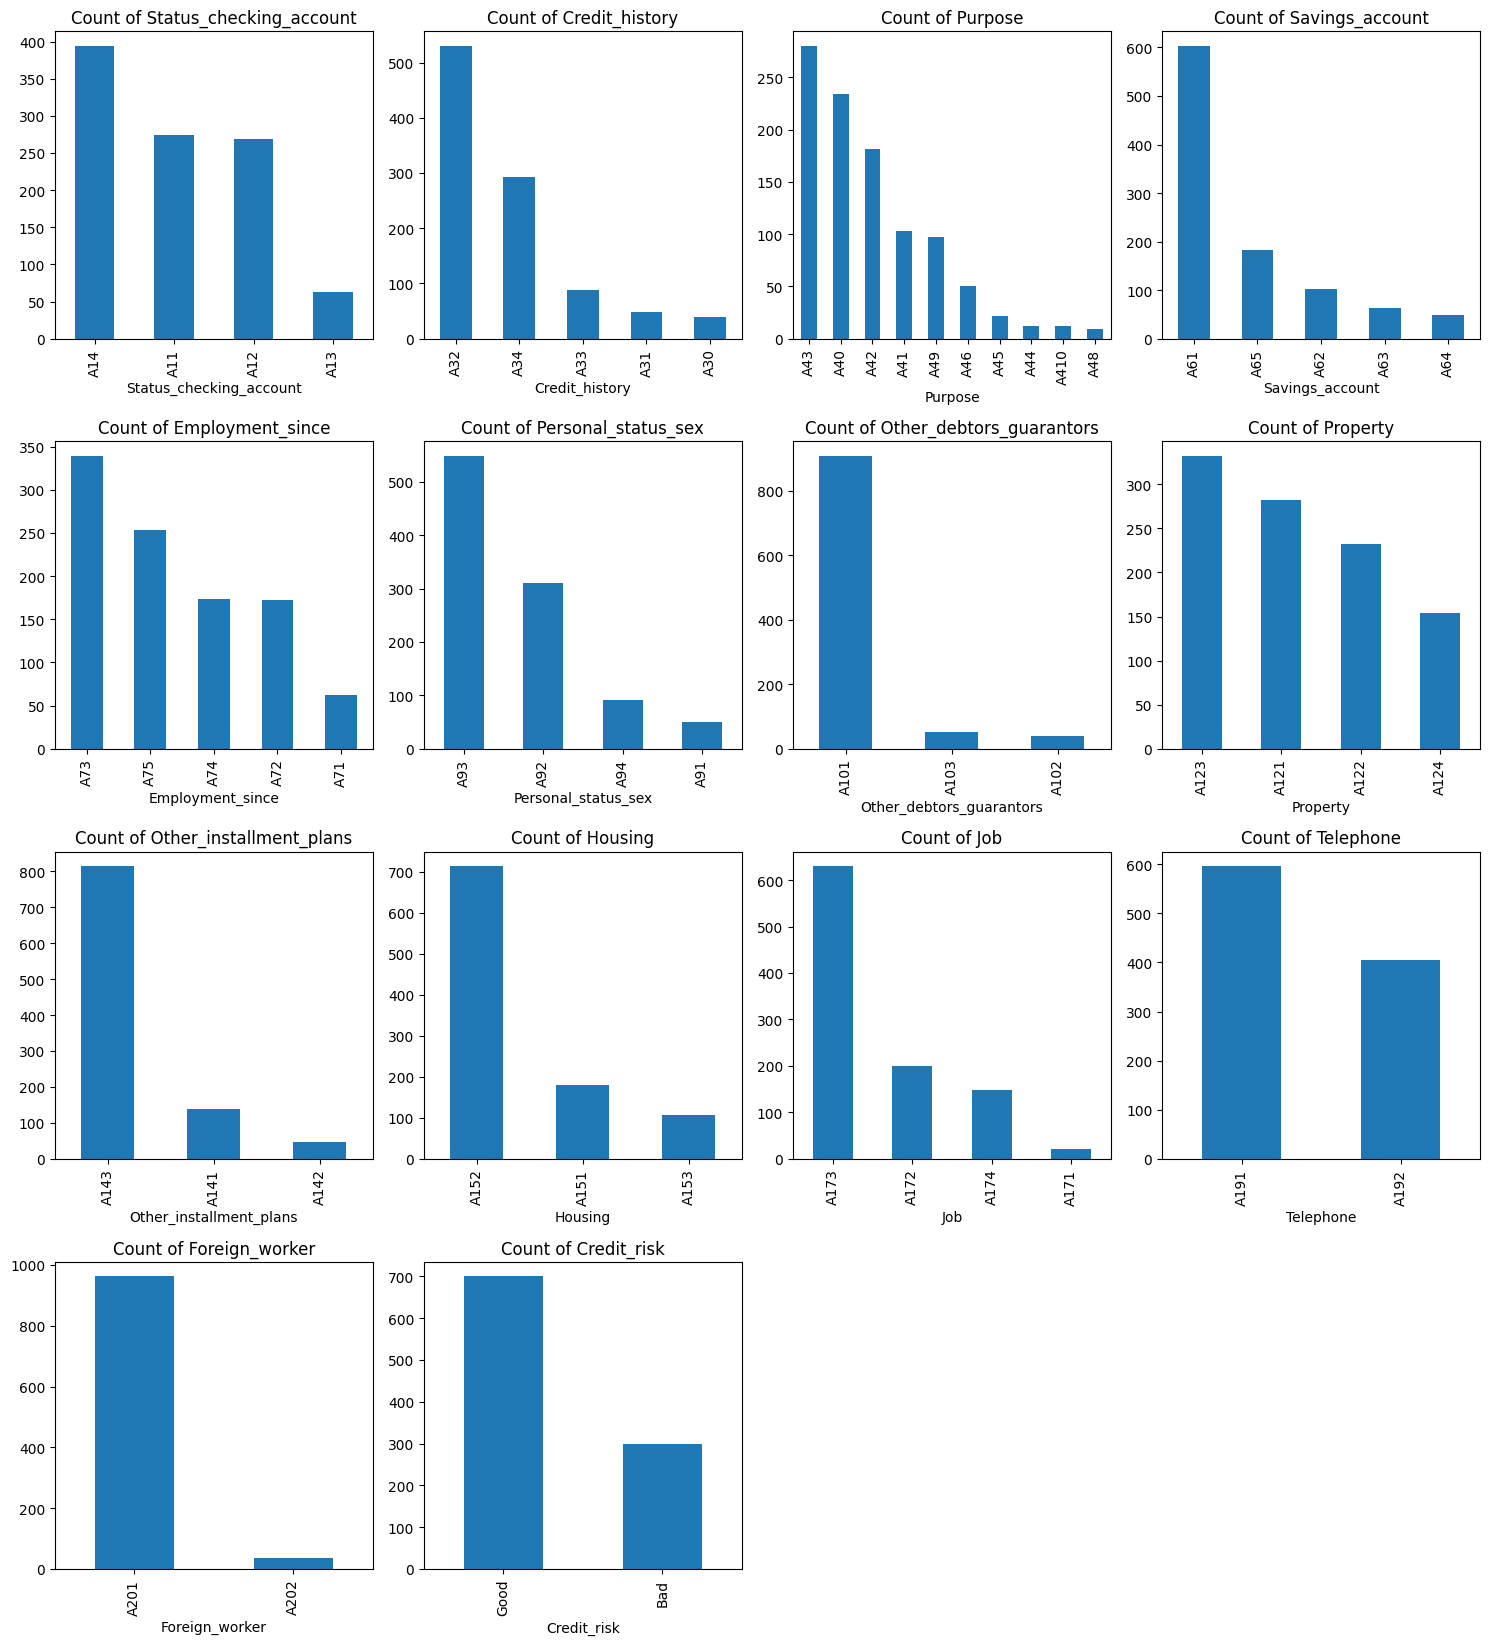

In [10]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(categorical_cols):
    plt.subplot(5, 4, i+1)
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Count of {col}")
plt.tight_layout()
plt.show()

Target distribution (Credit_risk)

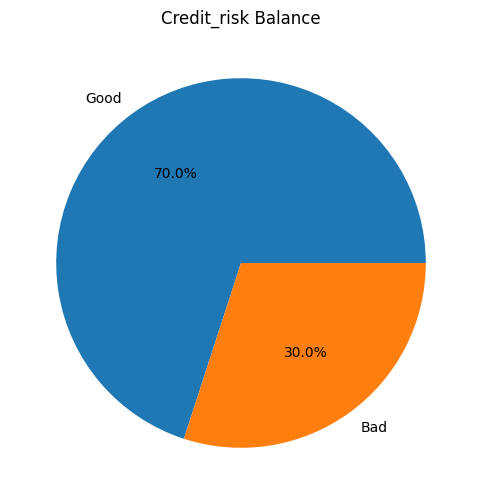

In [11]:
plt.figure(figsize=(6, 6))
df["Credit_risk"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Credit_risk Balance")
plt.ylabel("")
plt.show()

Summary

The dataset contains skewed financial variables, categorical variables dominated by a few classes, and a clear imbalance in the target.

Outliers appear meaningful and should be preserved.

Feature scaling and proper categorical encoding will be essential.

The class imbalance motivates the use of balanced metrics and potentially resampling techniques during model training.

#### 1.2 Correlation Analysis

Correlation matrix (numerical features)

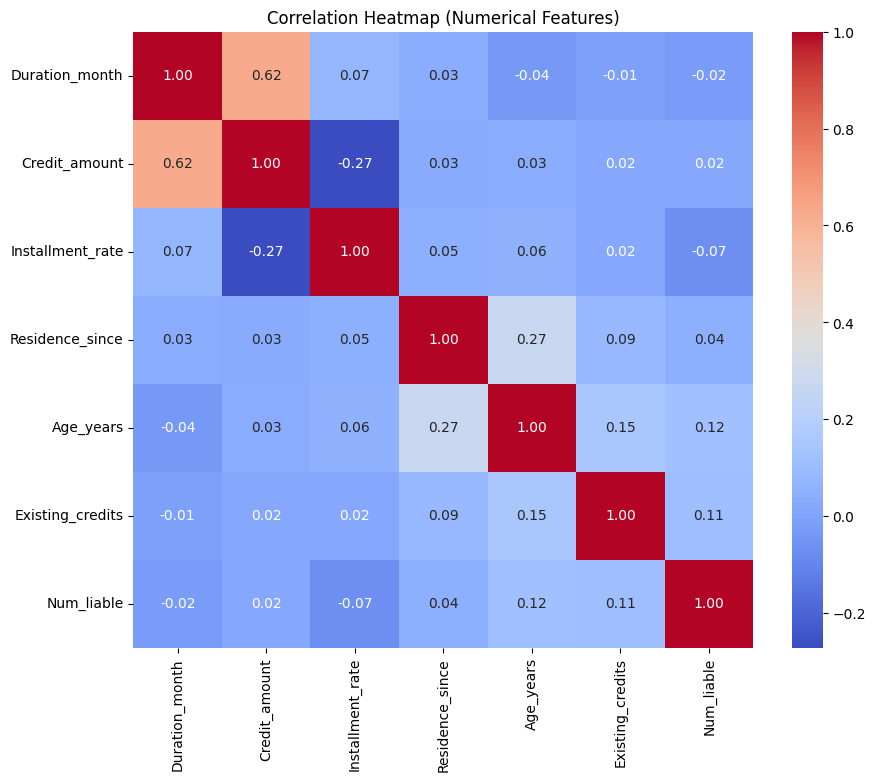

In [12]:
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

Pairplot of numerical variables

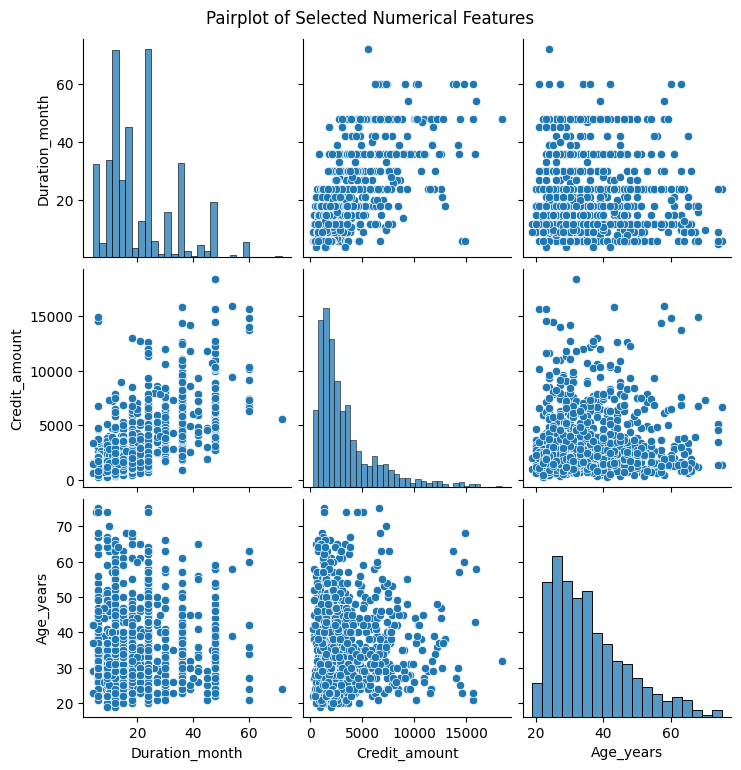

In [13]:
# Selecting a subset of numerical features for clarity
pairplot_cols = ["Duration_month", "Credit_amount", "Age_years"]

sns.pairplot(df[pairplot_cols])
plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
plt.show()

Correlation with target

In [14]:
# Encode the target
df_corr = df.copy()
df_corr["Credit_risk_encoded"] = df_corr["Credit_risk"].map({"Good": 0, "Bad": 1})

# Keep only numerical features + encoded target
num_for_corr = df_corr.select_dtypes(include=['int64', 'float64'])

# Compute correlation with the encoded target
target_corr = num_for_corr.corr()["Credit_risk_encoded"].sort_values(ascending=False)

print("Correlation of numerical features with Credit_risk:")
print(target_corr)


Correlation of numerical features with Credit_risk:
Credit_risk_encoded    1.000000
Duration_month         0.214927
Credit_amount          0.154739
Installment_rate       0.072404
Residence_since        0.002967
Num_liable            -0.003015
Existing_credits      -0.045732
Age_years             -0.091127
Name: Credit_risk_encoded, dtype: float64


Barplot of top correlations with the target

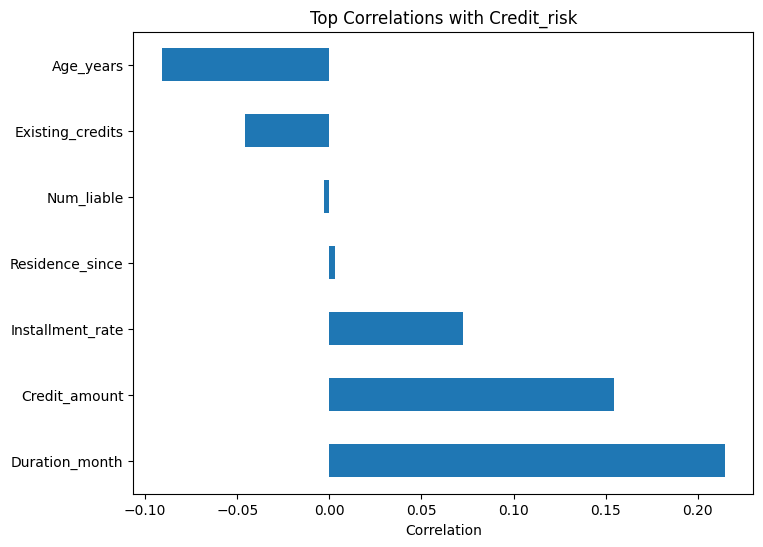

In [15]:
plt.figure(figsize=(8, 6))
target_corr.drop("Credit_risk_encoded").head(10).plot(kind='barh')
plt.title("Top Correlations with Credit_risk")
plt.xlabel("Correlation")
plt.show()

The dataset displays low linear correlations, both between numerical features and with the target.

This suggests that:

Linear models may perform poorly alone, unless combined with polynomial/higher-order interactions.

Tree-based models (Random Forest, Gradient Boosting, XGBoost) are likely more effective.

Categorical variables, once encoded, will carry most of the predictive power, since numerical variables provide only weak signals.

#### 1.3 Categorical features and target

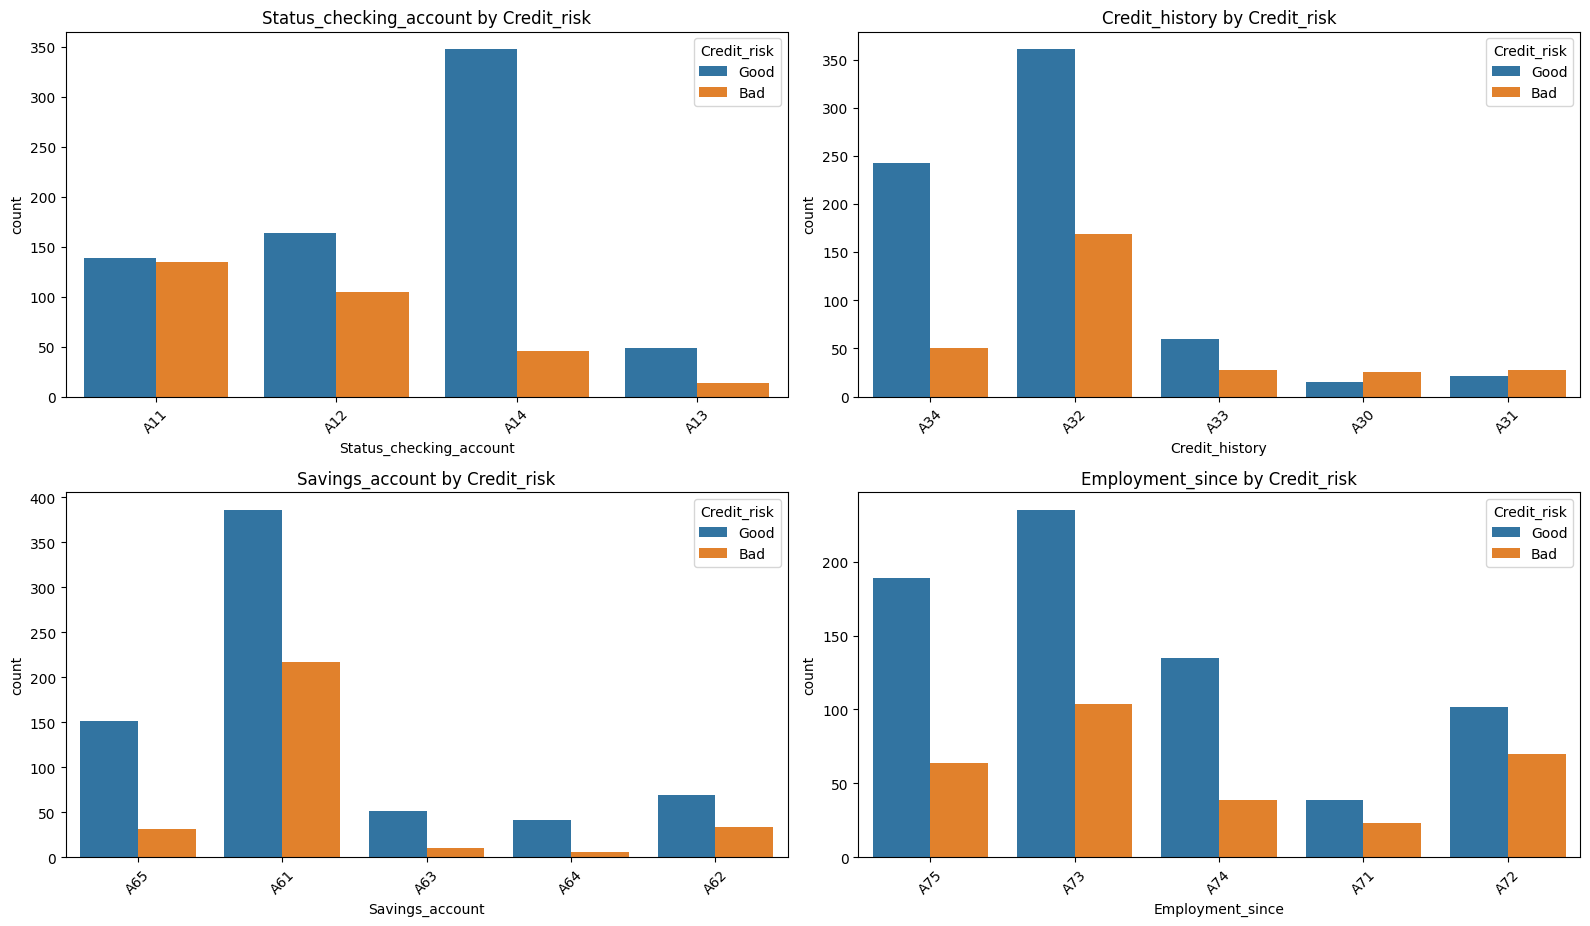

In [16]:
# Key categorical features to compare with the target
cat_for_target = [
    "Status_checking_account",
    "Credit_history",
    "Savings_account",
    "Employment_since"
]

plt.figure(figsize=(16, 18))
for i, col in enumerate(cat_for_target, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df, x=col, hue="Credit_risk")
    plt.title(f"{col} by Credit_risk")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Clients with :<br>
strong financial history (A34, high savings),<br>
stable employment (A73, A75),<br>
positive account status (A14)<br>
have Good credit risk.<br>

Clients with<br>
weak credit history (A30, A31),<br>
no savings (A61),<br>
short employment duration (A71),<br>
less favorable account status (A11, A12),<br>
show a significantly higher chance of being Bad credit risk.

#### 1.4 Relation features and target

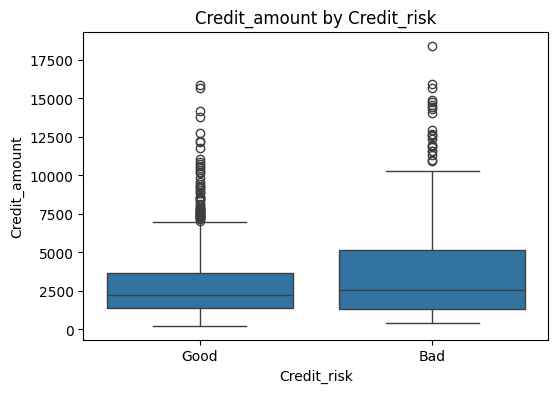

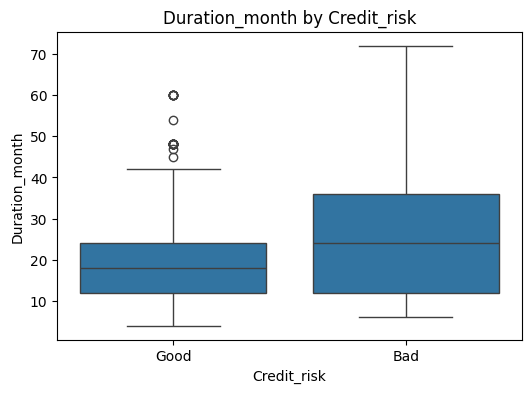

In [17]:
# Boxplot: Credit_amount by Credit_risk
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="Credit_risk", y="Credit_amount")
plt.title("Credit_amount by Credit_risk")
plt.show()

# Boxplot: Duration_month by Credit_risk
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="Credit_risk", y="Duration_month")
plt.title("Duration_month by Credit_risk")
plt.show()


Both Credit_amount and Duration_month show clear separation between Good and Bad clients.
They are strong features that should help the model differentiate between low-risk and high-risk customers.

#### 1.5 PCA analysis

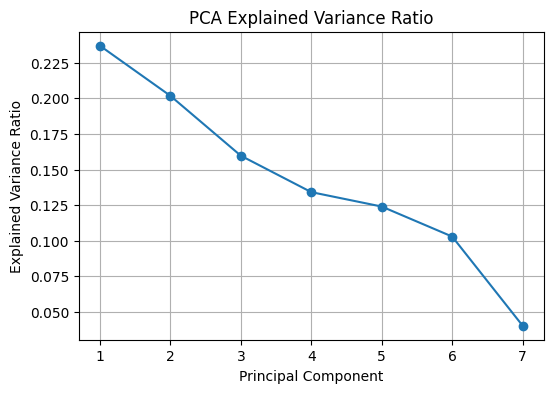

In [18]:
from sklearn.decomposition import PCA

# Select numerical features only
X_num = df[numeric_cols]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# PCA with all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker="o")
plt.title("PCA Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()


The dataset is high-dimensional, with no strong linear direction capturing most of the variance. <br>
This suggests that:<br>
The data is relatively complex,<br>
PCA alone can't create a clear separation between credit risk classes,<br>
Non-linear models (Random Forest, Gradient Boosting, XGBoost) will likely perform better than linear ones.

#### -- Data Pre-processing

In this section, we check the dataset quality before encoding and scaling.
We verify the presence of missing values, duplicates, potential outliers, and general consistency of the dataset.


In [19]:
# Checking for missing values
print("Missing values per column:")
print(df.isna().sum())

print("\nTotal missing values in the dataset:", df.isna().sum().sum())

# Checking for duplicated rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")



Missing values per column:
Status_checking_account     0
Duration_month              0
Credit_history              0
Purpose                     0
Credit_amount               0
Savings_account             0
Employment_since            0
Installment_rate            0
Personal_status_sex         0
Other_debtors_guarantors    0
Residence_since             0
Property                    0
Age_years                   0
Other_installment_plans     0
Housing                     0
Existing_credits            0
Job                         0
Num_liable                  0
Telephone                   0
Foreign_worker              0
Credit_risk                 0
dtype: int64

Total missing values in the dataset: 0
Number of duplicated rows: 0


we can see that there are no missings or duplicated values

### 2. Preprocessing

In [20]:
# Separate features and target
X = df.drop("Credit_risk", axis=1)
y = df["Credit_risk"]

# Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = label_encoder.fit_transform(X[col])

# Encode target labels (Good = 1, Bad = 0)
y = y.map({"Good": 1, "Bad": 0})

# Standardize numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 3. Problem formalization

The objective of this project is to predict the credit risk of a client based on their financial and personal information.

Each observation represents a customer with 20 input features such as:<br>
account status,<br>
credit history,<br>
loan purpose,<br>
employment status,<br>
age, housing, and others.<br>

The target variable (Credit_risk) takes two possible values:

"Good" → low risk (the customer is likely to repay the credit)<br>
"Bad" → high risk (the customer may default on payments)

Therefore, this is a supervised learning problem, more precisely a binary classification task.

Inputs (features): 20 independent variables (mix of categorical and numerical).<br>
Output (target): Binary label (Good / Bad).

Evaluation metric: Since the classes are slightly imbalanced, we will consider:<br>
Accuracy for overall performance.<br>
Precision, Recall, and F1-score to better capture class imbalance effects.

In [21]:
# Define input features (X) and target (y)
X = df.drop("Credit_risk", axis=1)
y = df["Credit_risk"]

print("Number of input features:", X.shape[1])
print("Target variable:", y.name)
print("Unique target classes:", y.unique())

Number of input features: 20
Target variable: Credit_risk
Unique target classes: ['Good' 'Bad']


### 4. Selection of a Baseline Model and Implementation

At this stage, we aim to establish a baseline model.

Given that our problem is a binary classification (Good / Bad credit risk) and that we have both numerical and categorical features, the chosen baseline model is a Logistic Regression classifier.

Reasons for this choice:<br>
It is simple and fast to train.<br>
It provides interpretable coefficients that indicate feature influence.<br>
It performs reasonably well on linearly separable data.

The model will be trained on the preprocessed dataset using an 80/20 train-test split.
The evaluation will include Accuracy, Precision, Recall, and F1-score to account for the class imbalance.

In [22]:
# Baseline model: Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
# Evaluation
print("Baseline Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Baseline Model Evaluation
Accuracy: 0.78

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.49      0.57        59
           1       0.81      0.90      0.85       141

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200



In [24]:
# Save preprocessed dataset
df.to_csv("german_credit_preprocessed.csv", index=False, sep=';', encoding='utf-8-sig')
print("Preprocessed dataset saved as 'german_credit_preprocessed.csv'")

Preprocessed dataset saved as 'german_credit_preprocessed.csv'


### Conclusion

The baseline Logistic Regression model achieved a acceptable overall accuracy of around 78%, indicating that the model can reasonably distinguish between good and bad credit risks.<br>
However, a closer look at the classification report reveals that the model performs significantly better on the “Good” class than on the “Bad” one.<br>
This imbalance suggests that the dataset is not perfectly balanced, which causes the model to favor the majority class (“Good”).

To improve performance, especially for detecting high-risk clients, the next steps should include:<br>
Applying class balancing techniques, such as SMOTE or class-weight adjustments during training.<br>
Exploring more robust models (Random Forest, Gradient Boosting, or XGBoost) that can better capture nonlinear relationships.<br>
Feature engineering and selection, to identify the most influential predictors of credit risk.

These improvements will allow the model to achieve better generalization and higher reliability for real-world credit risk assessment.

### 5. Dataset balancing : RandomOverSampler VS Smote

####  RandomOverSampler testing for improvements

In [36]:
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
print("Class distribution before ROS:")
print(y_train.value_counts().rename({1: 'Good', 0: 'Bad'}))

#ROS application
print("\nRandomOverSampler application ")
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("\nClass distribution after ROS:")
print(y_train_ros.value_counts().rename({1: 'Good', 0: 'Bad'}))

# ROS model training
model_ros = LogisticRegression(max_iter=1000, random_state=42)
model_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = model_ros.predict(X_test)

accuracy_ros = accuracy_score(y_test, y_pred_ros)
f1_ros = f1_score(y_test, y_pred_ros, pos_label=0)

print(f"\nRandomOverSampler evaluation :")
print(f"Accuracy: {accuracy_ros:.4f}")
print(f"F1-Score (Bad Risk): {f1_ros:.4f}\n")
print(classification_report(y_test, y_pred_ros))

Class distribution before ROS:
Credit_risk
Good    560
Bad     240
Name: count, dtype: int64

RandomOverSampler application 

Class distribution after ROS:
Credit_risk
Good    560
Bad     560
Name: count, dtype: int64

RandomOverSampler evaluation :
Accuracy: 0.7000
F1-Score (Bad Risk): 0.5946

              precision    recall  f1-score   support

           0       0.50      0.73      0.59        60
           1       0.86      0.69      0.76       140

    accuracy                           0.70       200
   macro avg       0.68      0.71      0.68       200
weighted avg       0.75      0.70      0.71       200



Adding a RandomOverSampler to our data improves massively our minority class recall score but it degrades the overall accuracy by almost 10%

#### SMOTE

In [26]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Split features and target
X = df.drop("Credit_risk", axis=1)
y = df["Credit_risk"].map({"Good": 1, "Bad": 0})  # cible numérique

# to do preprocessing steps
X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le  # si tu veux garder les encoders

# standardize numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

# 4) Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [37]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

print("Repartition of classes in y_train BEFORE SMOTE :", Counter(y_train))
print("Repartition of classes in y_test  :", Counter(y_test))

# SMOTE o n TRAIN set
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Size of X_train_res :", X_train_res.shape)
print("Repartition of classes in y_train AFTER SMOTE :", Counter(y_train_res))

#Logistic Regression 
model_smote = LogisticRegression(max_iter=1000, random_state=42)
model_smote.fit(X_train_res, y_train_res)

# Evaluation
y_pred_smote = model_smote.predict(X_test)

print("SMOTE Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nClassification report:\n", classification_report(y_test, y_pred_smote))


Repartition of classes in y_train BEFORE SMOTE : Counter({1: 560, 0: 240})
Repartition of classes in y_test  : Counter({1: 140, 0: 60})
Size of X_train_res : (1120, 20)
Repartition of classes in y_train AFTER SMOTE : Counter({1: 560, 0: 560})
SMOTE Model Evaluation
Accuracy: 0.68

Classification report:
               precision    recall  f1-score   support

           0       0.48      0.68      0.56        60
           1       0.83      0.68      0.75       140

    accuracy                           0.68       200
   macro avg       0.66      0.68      0.65       200
weighted avg       0.73      0.68      0.69       200



Confusion Matrix:
[[41 19]
 [45 95]]


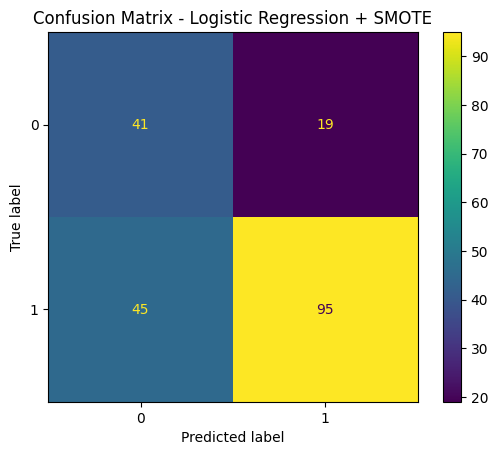

In [28]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_smote)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Logistic Regression + SMOTE")
plt.show()


AUC Score: 0.7763


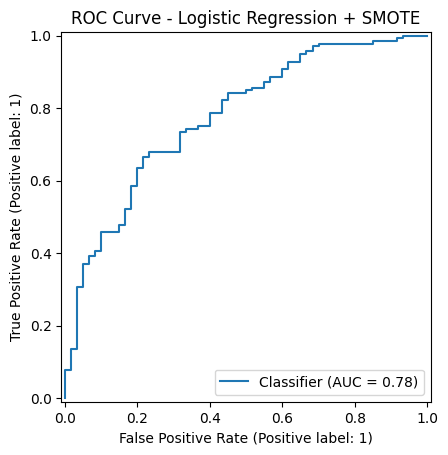

In [29]:
# ROC Curve and AUC

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

y_proba_smote = model_smote.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_proba_smote)
print(f"AUC Score: {auc_score:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba_smote)
plt.title("ROC Curve - Logistic Regression + SMOTE")
plt.show()


### 6.Optimisation with GridSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Modèle de base
log_reg = LogisticRegression(max_iter=1000)

# Grille d'hyperparamètres
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  
}


# Grid Search avec cross-validation
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)


print("Best hyperparameters found :", grid.best_params_)
print("Best CV score :", grid.best_score_)


best_log_reg = grid.best_estimator_
best_log_reg.fit(X_train, y_train)

y_pred = best_log_reg.predict(X_test)


from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("\nClassification report :\n", classification_report(y_test, y_pred))



Meilleurs hyperparamètres trouvés : {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur score CV : 0.7027360156824838
Accuracy : 0.75
F1-score : 0.8226950354609929

Classification report :
               precision    recall  f1-score   support

           0       0.59      0.57      0.58        60
           1       0.82      0.83      0.82       140

    accuracy                           0.75       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.75      0.75      0.75       200



We can see that with GridSearchCV optimisation, our recall for 0 (bad people) is lower than without it. We have 0.52 against 0.76 (RandomOverSampler). Thus, we will not need it.

!! It is important to look at the recall bc we want to know those who will not pay !!

### 7. Dimension Reduction with PCA

7. Dimension Reduction with PCA

Explained variance ratio by component:
[0.12317879 0.09869421 0.0732626  0.06697999 0.06325863 0.05848666
 0.0548473  0.05390493 0.04923178 0.04547316 0.04233163 0.04097385
 0.03895876 0.03836368 0.03459571 0.03151346 0.02611139 0.02402219
 0.02319046 0.01262082]

Cumulative explained variance:
[0.12317879 0.221873   0.29513561 0.3621156  0.42537422 0.48386089
 0.53870818 0.59261311 0.64184489 0.68731805 0.72964968 0.77062352
 0.80958228 0.84794596 0.88254167 0.91405513 0.94016652 0.96418871
 0.98737918 1.        ]


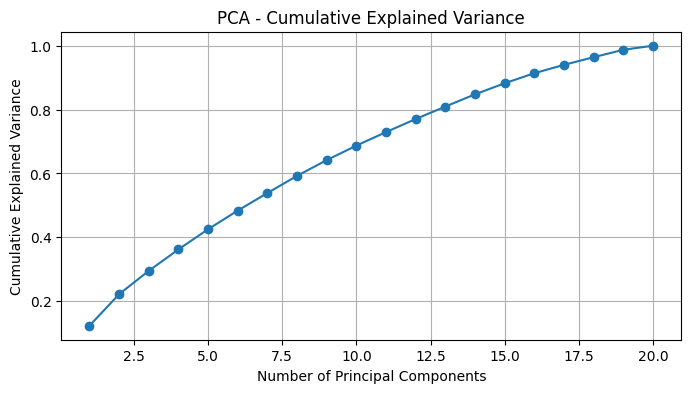

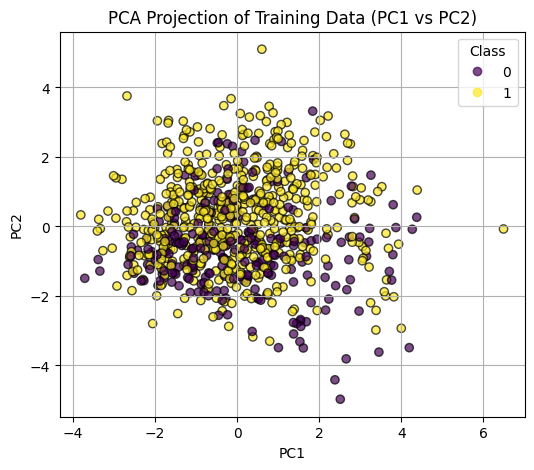


Number of components to reach at least 95% variance: 18

=== Logistic Regression with PCA-transformed features ===
Accuracy (LogReg + PCA): 0.745

Classification report (LogReg + PCA):

              precision    recall  f1-score   support

           0     0.5849    0.5167    0.5487        60
           1     0.8027    0.8429    0.8223       140

    accuracy                         0.7450       200
   macro avg     0.6938    0.6798    0.6855       200
weighted avg     0.7374    0.7450    0.7402       200



In [34]:


from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

print("7. Dimension Reduction with PCA\n")

# Fit PCA on the training data (without SMOTE)
pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained variance ratio by component:")
print(explained_variance)

print("\nCumulative explained variance:")
print(cumulative_variance)

# Plot cumulative explained variance 
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()

# 2D projection on the first two principal components
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_train_pca_2d[:, 0],
    X_train_pca_2d[:, 1],
    c=y_train,
    alpha=0.7,
    edgecolor="k"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Training Data (PC1 vs PC2)")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()

# Keep enough components to reach at least 95% of variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components to reach at least 95% variance: {n_components_95}")

pca_final = PCA(n_components=n_components_95)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

# Logistic Regression on PCA-transformed data
log_reg_pca = LogisticRegression(max_iter=1000, random_state=42)
log_reg_pca.fit(X_train_pca, y_train)
y_pred_pca = log_reg_pca.predict(X_test_pca)

print("\n=== Logistic Regression with PCA-transformed features ===")
print("Accuracy (LogReg + PCA):", accuracy_score(y_test, y_pred_pca))
print("\nClassification report (LogReg + PCA):\n")
print(classification_report(y_test, y_pred_pca, digits=4))



PCA is applied here mainly for methodological illustration. The dataset has a relatively small number of features, so dimensionality
reduction does not significantly improve computational efficiency.
Moreover, PCA reduces interpretability, which is important in credit scoring.
We observe that the performance of Logistic Regression with PCA is similar
to the original model, confirming that PCA is not strictly necessary in this
specific context, but it is useful to understand the technique.


The Logistic Regression model using PCA performs slightly worse than the baseline
model (accuracy 0.745 vs. 0.78). Since PCA keeps 18 components to preserve 95%
of the variance, the dimensionality reduction is minimal and the transformation
even reduces the interpretability of the model. These results confirm that PCA
does not provide meaningful benefits for this dataset, and is included mainly
for methodological completeness.
